In [1]:
import pandas as pd

# Load your dataset
df_earthquake = pd.read_csv('final_dataset.csv')
df_earthquake['image_ids_before'] = df_earthquake['image_ids_before'].astype(str)
df_earthquake['image_ids_after'] = df_earthquake['image_ids_after'].astype(str)

# Visualizza il risultato
print(df_earthquake.head())

   index                                        description  \
0      1  {'text': 'Iran-Iraq border region', 'type': 'F...   
1      2  {'text': 'Iran-Iraq border region', 'type': 'F...   
2      3  {'text': 'Myanmar', 'type': 'Flinn-Engdahl reg...   
3      4  {'text': 'Gulf of California', 'type': 'Flinn-...   
4      5  {'text': 'Fiji Islands region', 'type': 'Flinn...   

                      time  latitude  longitude     depth  magnitude  \
0  2018-01-11 06:59:31.600   33.7388    45.7501   19388.0       5.58   
1  2018-01-11 08:00:40.440   33.7047    45.7355   19493.5       5.37   
2  2018-01-11 18:26:24.180   18.3513    95.9959   11230.7       5.97   
3  2018-01-19 16:17:44.780   26.6196  -110.9457   10000.0       5.65   
4  2018-01-25 10:41:13.430  -17.8051  -179.5737  627266.3       4.82   

  magnitude_type                                   image_ids_before  \
0             mb  S1A_IW_SLC__1SDV_20180106T025411_20180106T0254...   
1             mb  S1A_IW_SLC__1SDV_20180110T14

In [2]:
#map
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import datetime
import rasterio
import zipfile
import os
import csv
import snapista
import sys
sys.path.append('/home/ebuccoliero/miniforge3/envs/snappp/snap/.snap/snap-python/snappy')
import snappy
import pyroSAR
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyproj
import h5py

from pyproj import CRS
from cartopy.io.img_tiles import OSM
from matplotlib.patches import Rectangle
from snappy import ProductIO, GPF, HashMap
from shapely.geometry import Point
from pathlib import Path
from pprint import pprint
from ost import Sentinel1Scene
from pyroSAR import identify
from pyroSAR.snap import geocode
from snapista import Graph

INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Incompatible GDAL 3.7.0 found on system. Internal GDAL 3.0.0 from distribution will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Internal GDAL 3.0.0 set to be used by SNAP.
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
Currently installed 8.0, available is 11.0.0.
Please visit http://step.esa.int



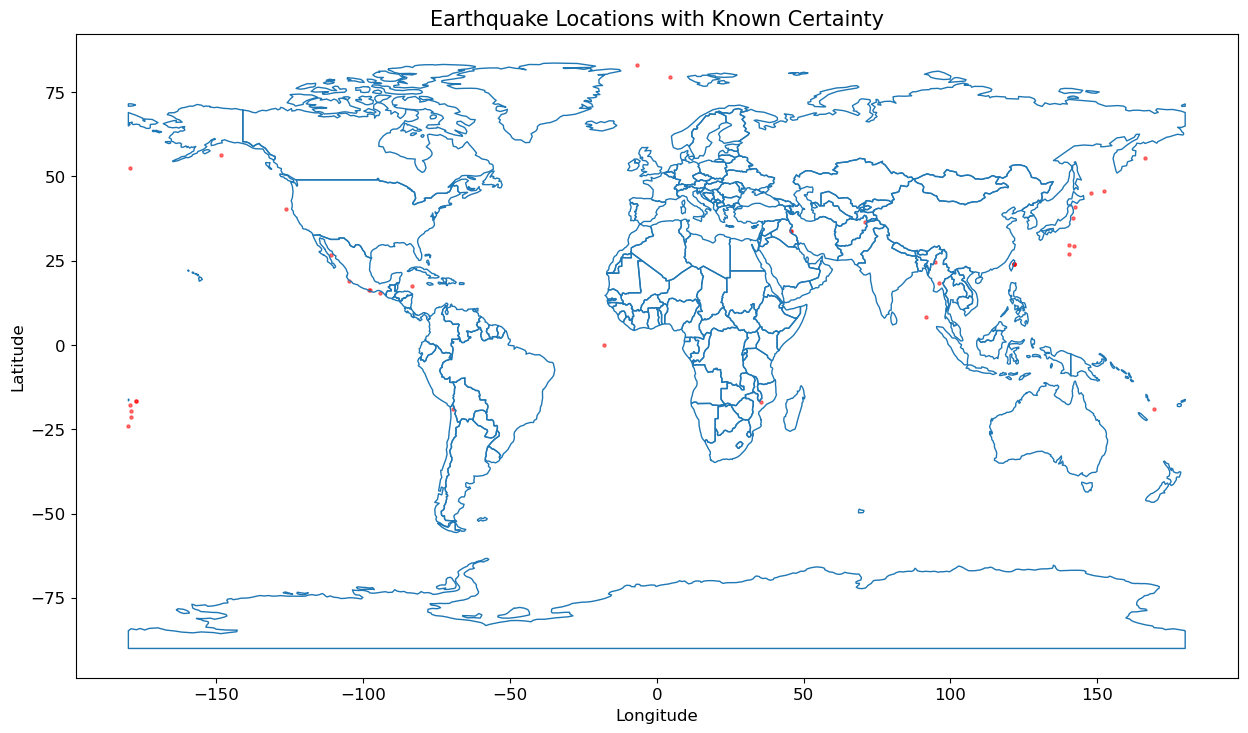

In [3]:

# Load the data and create geometry column
dfp = pd.read_csv('df_all_earthquake.csv')
dfp1 = dfp[['latitude', 'longitude']].copy()
geometry = [Point(x, y) for x, y in zip(dfp1['longitude'], dfp1['latitude'])]

# Create a GeoDataFrame with the specified coordinate system
gdf = gpd.GeoDataFrame(dfp1, geometry=geometry, crs='epsg:4326')

# Load country boundaries
world = gpd.read_file('ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

# Create a figure and an axis
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot country boundaries
world.boundary.plot(ax=ax, linewidth=1)

# Plot only the first 40 earthquake points
gdf.head(40).plot(ax=ax, color='red', markersize=5, alpha=0.5)

# Add title and labels
ax.set_title('Earthquake Locations with Known Certainty', fontsize=15)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the map
plt.show()

# Start the resize

In [2]:
#try the first IW3

import h5py
import numpy as np
import cv2
import pandas as pd

# Specifica il percorso del file HDF5 di input
input_h5_path = '/data3/ebuccoliero/Images/Image1/Interferogram_1_IW3.h5'
output_h5_path = '/data3/ebuccoliero/Resized_interferograms/Earthquake1_IW3/prova_interferograms.h5'  # Percorso del file HDF5 di output

# Carica il file dei metadati
metadata_file_path = '/data3/ebuccoliero/metadata_coordinates_sorted.csv'  # Percorso del file CSV con i metadati
metadata_df = pd.read_csv(metadata_file_path)

# Ridefinisci patch_data e resized_patches
patch_data = []
resized_patches = []

# Carica il file HDF5
with h5py.File(input_h5_path, 'r') as f:
    i_ifg = f['bands/i_ifg_VV_06Jan2018_18Jan2018'][:]  # Parte reale
    q_ifg = f['bands/q_ifg_VV_06Jan2018_18Jan2018'][:]  # Parte immaginaria

# Dimensioni dell'immagine
height, width = i_ifg.shape
patch_size = 2000
resize_shape = (256, 256)

# Estrai le coordinate del subswath dal file dei metadati
subs = metadata_df.loc[metadata_df['interferogram'] == 'Interferogram_1_IW3'].iloc[0]
first_far = (subs['first_far_lat'], subs['first_far_long'])
first_near = (subs['first_near_lat'], subs['first_near_long'])
last_far = (subs['last_far_lat'], subs['last_far_long'])
last_near = (subs['last_near_lat'], subs['last_near_long'])

# Itera sull'immagine per estrarre e ridimensionare le patch
for y in range(0, height, patch_size):
    for x in range(0, width, patch_size):
        y_end = min(y + patch_size, height)
        x_end = min(x + patch_size, width)
        
        # Estrai la patch
        patch_i = i_ifg[y:y_end, x:x_end]
        patch_q = q_ifg[y:y_end, x:x_end]
        
        # Ridimensiona la patch a 256x256
        resized_i = cv2.resize(patch_i, resize_shape, interpolation=cv2.INTER_AREA)
        resized_q = cv2.resize(patch_q, resize_shape, interpolation=cv2.INTER_AREA)
        
        # Salva le patch ridimensionate
        resized_patches.append((resized_i, resized_q))
        
        # Calcola le coordinate interpolate per la patch
        lat_top_left = np.interp(y, [0, height], [first_far[0], last_far[0]])
        lon_top_left = np.interp(x, [0, width], [first_far[1], last_far[1]])
        lat_top_right = np.interp(y, [0, height], [first_near[0], last_near[0]])
        lon_top_right = np.interp(x_end, [0, width], [first_near[1], last_near[1]])
        lat_bottom_left = np.interp(y_end, [0, height], [first_far[0], last_far[0]])
        lon_bottom_left = np.interp(x, [0, width], [first_far[1], last_far[1]])
        lat_bottom_right = np.interp(y_end, [0, height], [first_near[0], last_near[0]])
        lon_bottom_right = np.interp(x_end, [0, width], [first_near[1], last_near[1]])
        
        # Aggiungi i dati delle coordinate
        patch_data.append({
            'patch_index': len(patch_data) + 1,
            'lat_top_left': lat_top_left,
            'lon_top_left': lon_top_left,
            'lat_top_right': lat_top_right,
            'lon_top_right': lon_top_right,
            'lat_bottom_left': lat_bottom_left,
            'lon_bottom_left': lon_bottom_left,
            'lat_bottom_right': lat_bottom_right,
            'lon_bottom_right': lon_bottom_right
        })

# Salva le patch ridimensionate in un file HDF5
with h5py.File(output_h5_path, 'w') as f_out:
    for index, (resized_i, resized_q) in enumerate(resized_patches):
        dataset_name_i = f'patch_{index + 1}/i_ifg'
        dataset_name_q = f'patch_{index + 1}/q_ifg'
        f_out.create_dataset(dataset_name_i, data=resized_i)
        f_out.create_dataset(dataset_name_q, data=resized_q)

# Salva le coordinate in un file CSV
patch_df = pd.DataFrame(patch_data)
patch_df.to_csv('/data3/ebuccoliero/Resized_interferograms/Earthquake1_IW3/prova.csv', index=False)

print("Le patch ridimensionate e le coordinate sono state salvate con successo.")

Le patch ridimensionate e le coordinate sono state salvate con successo.


/tmp/ipykernel_3139364/4122755436.py:63: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='upper right')
/tmp/ipykernel_3139364/4122755436.py:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


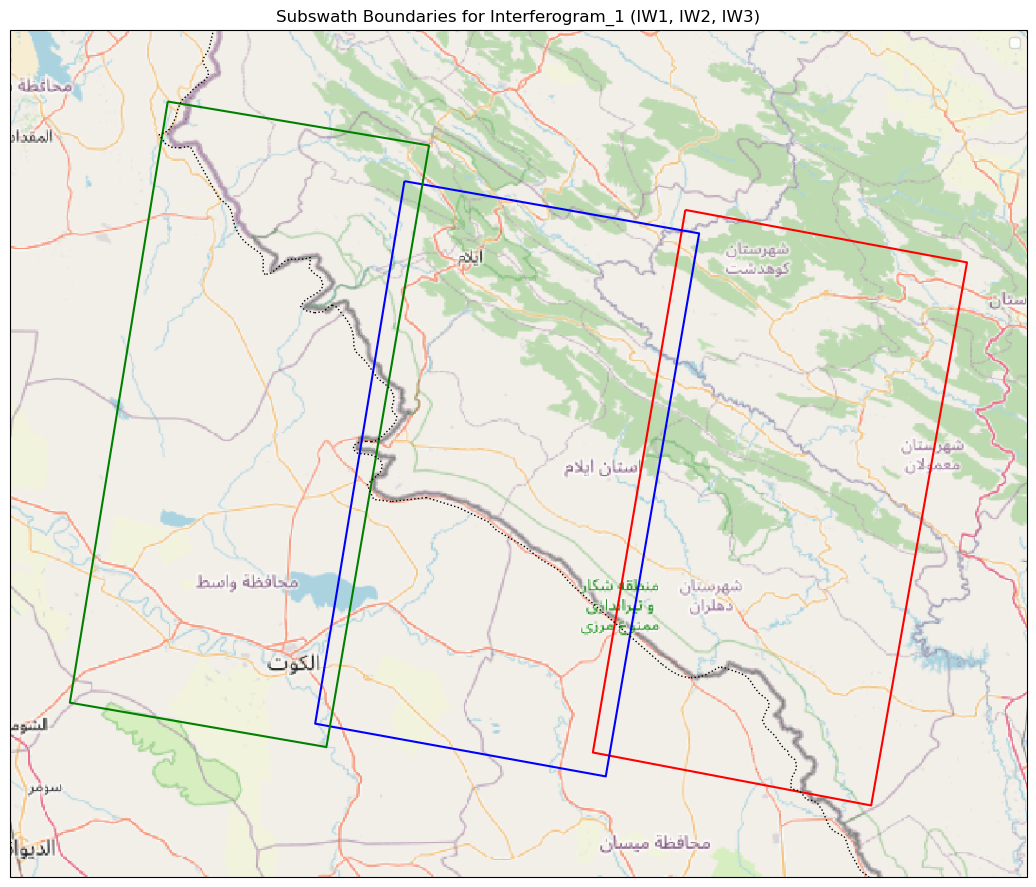

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon
from cartopy.io.img_tiles import OSM
import geopandas as gpd

# Load metadata CSV
file_path = '/data3/ebuccoliero/metadata_coordinates_sorted.csv'  # Update with your actual file path
metadata_df = pd.read_csv(file_path)

# Filter data for Interferogram_1 IW1, IW2, IW3
interferograms = ['Interferogram_1_IW1', 'Interferogram_1_IW2', 'Interferogram_1_IW3']
filtered_subswaths = metadata_df[metadata_df['interferogram'].isin(interferograms)]

# Check if the filtered DataFrame is empty
if filtered_subswaths.empty:
    print("No relevant subswath data found for the specified conditions.")
else:
    # Create GeoDataFrame for all subswaths
    polygons = []
    for _, row in filtered_subswaths.iterrows():
        corners = [
            (row['first_far_long'], row['first_far_lat']),
            (row['first_near_long'], row['first_near_lat']),
            (row['last_near_long'], row['last_near_lat']),
            (row['last_far_long'], row['last_far_lat']),
            (row['first_far_long'], row['first_far_lat'])  # Closing the polygon
        ]
        polygons.append(Polygon(corners))
    
    # Create a GeoDataFrame for all subswaths
    subswath_gdf = gpd.GeoDataFrame(
        {'interferogram': filtered_subswaths['interferogram'], 'geometry': polygons},
        crs="EPSG:4326"
    )
    
    # Plotting the subswaths on a map with Cartopy
    fig, ax = plt.subplots(figsize=(15, 11), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.COASTLINE)

    # Determine extent for all subswaths
    min_lon, min_lat, max_lon, max_lat = subswath_gdf.total_bounds
    margin = 0.2  # Add a small margin for better visualization
    ax.set_extent([min_lon - margin, max_lon + margin, min_lat - margin, max_lat + margin])

    # Add OSM background map
    tile = OSM()
    ax.add_image(tile, 8)  # Adjust zoom level as needed

    # Plot each subswath polygon
    colors = ['red', 'blue', 'green']  # Colors for different interferograms
    for i, (name, group) in enumerate(subswath_gdf.groupby('interferogram')):
        group.plot(
            ax=ax, edgecolor=colors[i], facecolor='none', linewidth=1.5,
            label=name, transform=ccrs.PlateCarree()
        )

    # Configure the plot
    plt.title("Subswath Boundaries for Interferogram_1 (IW1, IW2, IW3)")
    plt.legend(loc='upper right')
    plt.show()

In [9]:
#visualize plot
import pandas as pd
import matplotlib.pyplot as plt

# Carica il file CSV delle coordinate delle patch
coordinates_df = pd.read_csv('/data3/ebuccoliero/Resized_interferograms/Earthquake1_IW1/prova.csv')

# Carica il file CSV dei metadati
metadata_df = pd.read_csv('/data3/ebuccoliero/metadata_coordinates_sorted.csv')

# Estrai le coordinate delle patch
patch_lats = [
    [row['lat_top_left'], row['lat_top_right'], row['lat_bottom_right'], row['lat_bottom_left'], row['lat_top_left']]
    for _, row in coordinates_df.iterrows()
]
patch_lons = [
    [row['lon_top_left'], row['lon_top_right'], row['lon_bottom_right'], row['lon_bottom_left'], row['lon_top_left']]
    for _, row in coordinates_df.iterrows()
]

# Estrai le coordinate del subswath dal file dei metadati per Interferogram_1_IW3
subs = metadata_df.loc[metadata_df['interferogram'] == 'Interferogram_1_IW1'].iloc[0]
subswath_coords = [
    (subs['first_far_lat'], subs['first_far_long']),
    (subs['first_near_lat'], subs['first_near_long']),
    (subs['last_near_lat'], subs['last_near_long']),
    (subs['last_far_lat'], subs['last_far_long']),
    (subs['first_far_lat'], subs['first_far_long'])  # Chiudi il loop
]

# Estrai le latitudini e longitudini del subswath
subswath_lats = [coord[0] for coord in subswath_coords]
subswath_lons = [coord[1] for coord in subswath_coords]

# Plot delle patch come contorni e confronto con l'area del subswath
plt.figure(figsize=(10, 6))

# Disegna ciascuna patch come un contorno (senza riempimento)
for lat, lon in zip(patch_lats, patch_lons):
    plt.plot(lon, lat, 'b--', alpha=0.6, label='Patch Borders' if patch_lats.index(lat) == 0 else "")

# Disegna il contorno dell'area del subswath
plt.plot(subswath_lons, subswath_lats, 'r-', linewidth=2, label='Subswath Boundary')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Compare Patches and Subswath area')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.grid(True)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/data3/ebuccoliero/Resized_interferograms/Earthquake1_IW1/prova.csv'

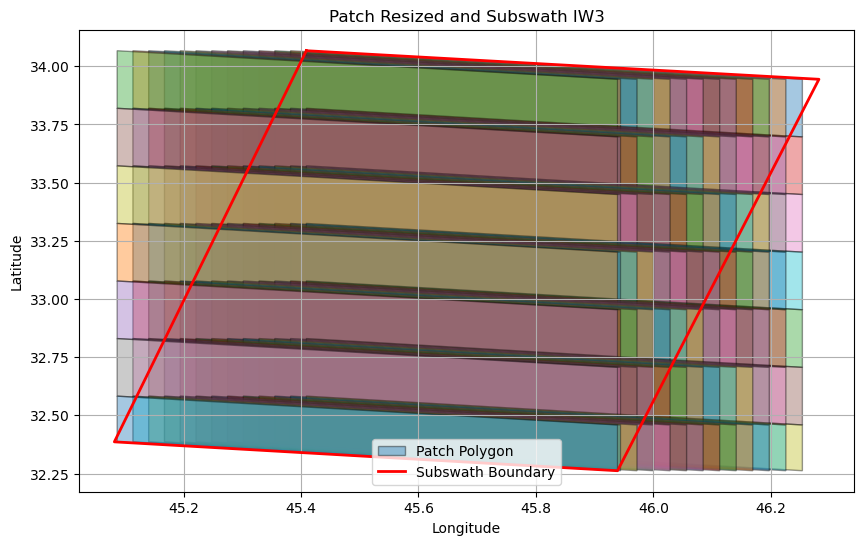

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica i file CSV delle coordinate delle patch ridimensionate e dei metadati
resized_coordinates_df = pd.read_csv('/data3/ebuccoliero/Resized_interferograms/Earthquake1_IW3/prova.csv')
metadata_df = pd.read_csv('/data3/ebuccoliero/metadata_coordinates_sorted.csv')

# Estrai le coordinate del subswath dal file dei metadati per Interferogram_1_IW3
subs = metadata_df.loc[metadata_df['interferogram'] == 'Interferogram_1_IW3'].iloc[0]
subswath_coords = [
    (subs['first_far_lat'], subs['first_far_long']),
    (subs['first_near_lat'], subs['first_near_long']),
    (subs['last_near_lat'], subs['last_near_long']),
    (subs['last_far_lat'], subs['last_far_long']),
    (subs['first_far_lat'], subs['first_far_long'])  # Chiudi il loop
]

# Estrai le latitudini e longitudini del subswath
subswath_lats = [coord[0] for coord in subswath_coords]
subswath_lons = [coord[1] for coord in subswath_coords]

# Plot dei poligoni per ciascuna riga del file CSV
plt.figure(figsize=(10, 6))

# Disegna un poligono per ciascuna riga delle patch ridimensionate
for _, row in resized_coordinates_df.iterrows():
    lats = [row['lat_top_left'], row['lat_top_right'], row['lat_bottom_right'], row['lat_bottom_left'], row['lat_top_left']]
    lons = [row['lon_top_left'], row['lon_top_right'], row['lon_bottom_right'], row['lon_bottom_left'], row['lon_top_left']]
    plt.fill(lons, lats, alpha=0.4, edgecolor='black', label='Patch Polygon' if _ == 0 else "")

# Disegna il contorno dell'area del subswath
plt.plot(subswath_lons, subswath_lats, 'r-', linewidth=2, label='Subswath Boundary')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Patch Resized and Subswath IW3')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
#try the first 3

In [6]:
import h5py
import numpy as np
import cv2
import pandas as pd
import os

# Imposta i percorsi dei file di input e output
input_dir = '/data3/ebuccoliero/Images'
output_h5_path = '/data3/ebuccoliero/Resized_interferograms/all_resized_interferograms.h5'
metadata_file_path = '/data3/ebuccoliero/metadata_coordinates_sorted.csv'
metadata_df = pd.read_csv(metadata_file_path)

# Definisci la dimensione delle patch e le dimensioni ridimensionate
patch_size = 2000
resize_shape = (256, 256)

# Crea un file HDF5 per salvare tutte le patch
with h5py.File(output_h5_path, 'w') as f_out:
    # Itera su ciascun numero di immagine e ciascun subswath
    for image_index in range(1, 41):
        for subswath in ['IW1', 'IW2', 'IW3']:
            # Specifica il percorso del file HDF5 di input
            input_h5_path = os.path.join(input_dir, f'Image{image_index}/Interferogram_{image_index}_{subswath}.h5')

            # Controlla se il file di input esiste
            if not os.path.exists(input_h5_path):
                print(f"File {input_h5_path} non trovato. Saltando...")
                continue

            # Carica il file HDF5 e leggi le bande in modo dinamico
            with h5py.File(input_h5_path, 'r') as f:
                bands_group = f['bands']
                band_names = list(bands_group.keys())  # Ottieni tutte le bande disponibili

                # Dimensioni dell'immagine (assumiamo che tutte le bande abbiano la stessa dimensione)
                sample_band = bands_group[band_names[0]][:]
                height, width = sample_band.shape

                # Itera su tutte le bande disponibili
                for band_name in band_names:
                    band_data = bands_group[band_name][:]  # Carica i dati della banda

                    # Itera sull'immagine per estrarre e ridimensionare le patch
                    for y in range(0, height, patch_size):
                        for x in range(0, width, patch_size):
                            y_end = min(y + patch_size, height)
                            x_end = min(x + patch_size, width)
                            
                            # Estrai la patch
                            patch = band_data[y:y_end, x:x_end]
                            
                            # Ridimensiona la patch a 256x256
                            resized_patch = cv2.resize(patch, resize_shape, interpolation=cv2.INTER_AREA)
                            
                            # Crea il percorso per il dataset nel file HDF5
                            base_path = f'Interferogram_{image_index}/{subswath}/{band_name}'
                            dataset_name = f'{base_path}/patch_{y}_{x}'

                            # Salva la patch ridimensionata nel file HDF5
                            f_out.create_dataset(dataset_name, data=resized_patch)

            print(f"Le patch ridimensionate per Image{image_index} {subswath} sono state salvate con successo.")

print("Tutte le patch ridimensionate sono state salvate nel file HDF5 con la struttura corretta.")

Le patch ridimensionate per Image1 IW1 sono state salvate con successo.
Le patch ridimensionate per Image1 IW2 sono state salvate con successo.
Le patch ridimensionate per Image1 IW3 sono state salvate con successo.
Le patch ridimensionate per Image2 IW1 sono state salvate con successo.
Le patch ridimensionate per Image2 IW2 sono state salvate con successo.
Le patch ridimensionate per Image2 IW3 sono state salvate con successo.
Le patch ridimensionate per Image3 IW1 sono state salvate con successo.
Le patch ridimensionate per Image3 IW2 sono state salvate con successo.
Le patch ridimensionate per Image3 IW3 sono state salvate con successo.


KeyboardInterrupt: 

In [1]:
import h5py
import os

# Path to the HDF5 file
file_path = '/data3/ebuccoliero/Resized_interferograms/all_resized_interferograms.h5'

# Check if the file exists
if os.path.exists(file_path):
    print(f"File '{file_path}' exists. Attempting to read structure...")

    # Open the file in read mode
    with h5py.File(file_path, 'r') as f:
        # Check if the file has any content
        if len(f.keys()) == 0:
            print("The file is empty or does not contain any groups or datasets.")
        else:
            # Define a function to recursively print the file structure
            def print_structure(name, obj):
                # Print the name of each object in the file (group or dataset)
                print(name)

            # Print the entire structure
            print("File structure:")
            f.visititems(print_structure)

else:
    print(f"File '{file_path}' does not exist. Please check the file path.")

File '/data3/ebuccoliero/Resized_interferograms/all_resized_interferograms.h5' exists. Attempting to read structure...
File structure:
Interferogram_10_IW1
Interferogram_10_IW1/coh_IW1_VV_03Feb2018_15Feb2018
Interferogram_10_IW1/coh_IW1_VV_03Feb2018_15Feb2018/patch_0_0
Interferogram_10_IW1/coh_IW1_VV_03Feb2018_15Feb2018/patch_0_10000
Interferogram_10_IW1/coh_IW1_VV_03Feb2018_15Feb2018/patch_0_12000
Interferogram_10_IW1/coh_IW1_VV_03Feb2018_15Feb2018/patch_0_14000
Interferogram_10_IW1/coh_IW1_VV_03Feb2018_15Feb2018/patch_0_16000
Interferogram_10_IW1/coh_IW1_VV_03Feb2018_15Feb2018/patch_0_18000
Interferogram_10_IW1/coh_IW1_VV_03Feb2018_15Feb2018/patch_0_2000
Interferogram_10_IW1/coh_IW1_VV_03Feb2018_15Feb2018/patch_0_20000
Interferogram_10_IW1/coh_IW1_VV_03Feb2018_15Feb2018/patch_0_4000
Interferogram_10_IW1/coh_IW1_VV_03Feb2018_15Feb2018/patch_0_6000
Interferogram_10_IW1/coh_IW1_VV_03Feb2018_15Feb2018/patch_0_8000
Interferogram_10_IW1/coh_IW1_VV_03Feb2018_15Feb2018/patch_10000_0
Interfer

In [14]:
import h5py
import numpy as np
import cv2
import pandas as pd
import os

# Imposta i percorsi dei file di input e output
input_dir = '/data3/ebuccoliero/Images'
output_h5_path = '/data3/ebuccoliero/Resized_interferograms/Earthquakes_1_2_3/resized_interferograms.h5'
metadata_file_path = '/data3/ebuccoliero/metadata_coordinates_sorted.csv'
output_csv_path = '/data3/ebuccoliero/Resized_interferograms/Earthquakes_1_2_3/patch_coordinates.csv'

# Carica il file dei metadati
metadata_df = pd.read_csv(metadata_file_path)

# Definisci la dimensione delle patch e le dimensioni ridimensionate
patch_size = 2000
resize_shape = (256, 256)

# Lista per memorizzare i dati delle coordinate delle patch
patch_coordinates = []

# Crea un file HDF5 per salvare tutte le patch
with h5py.File(output_h5_path, 'w') as f_out:
    # Itera su ciascun numero di immagine e ciascun subswath
    for image_index in range(1, 4):
        for subswath in ['IW1', 'IW2', 'IW3']:
            # Specifica il percorso del file HDF5 di input
            input_h5_path = os.path.join(input_dir, f'Image{image_index}/Interferogram_{image_index}_{subswath}.h5')

            # Controlla se il file di input esiste
            if not os.path.exists(input_h5_path):
                print(f"File {input_h5_path} non trovato. Saltando...")
                continue

            # Ottieni i metadati corrispondenti
            full_name = f'Interferogram_{image_index}_{subswath}'
            subs_metadata = metadata_df.loc[metadata_df['interferogram'] == full_name]

            if subs_metadata.empty:
                print(f"Nessun metadato trovato per {full_name}. Saltando...")
                continue

            # Estrai le coordinate dai metadati
            subs = subs_metadata.iloc[0]
            first_far = (subs['first_far_lat'], subs['first_far_long'])
            first_near = (subs['first_near_lat'], subs['first_near_long'])
            last_far = (subs['last_far_lat'], subs['last_far_long'])
            last_near = (subs['last_near_lat'], subs['last_near_long'])

            # Carica il file HDF5 e leggi le bande in modo dinamico
            with h5py.File(input_h5_path, 'r') as f:
                bands_group = f['bands']
                band_names = list(bands_group.keys())  # Ottieni tutte le bande disponibili

                # Dimensioni dell'immagine (assumiamo che tutte le bande abbiano la stessa dimensione)
                sample_band = bands_group[band_names[0]][:]
                height, width = sample_band.shape

                # Itera su tutte le bande disponibili
                for band_name in band_names:
                    band_data = bands_group[band_name][:]  # Carica i dati della banda

                    # Itera sull'immagine per estrarre e ridimensionare le patch
                    for y in range(0, height, patch_size):
                        for x in range(0, width, patch_size):
                            y_end = min(y + patch_size, height)
                            x_end = min(x + patch_size, width)
                            
                            # Estrai la patch
                            patch = band_data[y:y_end, x:x_end]
                            
                            # Ridimensiona la patch a 256x256
                            resized_patch = cv2.resize(patch, resize_shape, interpolation=cv2.INTER_AREA)
                            
                            # Crea il percorso per il dataset nel file HDF5
                            base_path = f'Interferogram_{image_index}/{subswath}/{band_name}'
                            dataset_name = f'{base_path}/patch_{y}_{x}'

                            # Salva la patch ridimensionata nel file HDF5
                            f_out.create_dataset(dataset_name, data=resized_patch)

                            # Calcola le coordinate interpolate per la patch
                            lat_top_left = np.interp(y, [0, height], [first_far[0], last_far[0]])
                            lon_top_left = np.interp(x, [0, width], [first_far[1], last_far[1]])
                            lat_top_right = np.interp(y, [0, height], [first_near[0], last_near[0]])
                            lon_top_right = np.interp(x_end, [0, width], [first_near[1], last_near[1]])
                            lat_bottom_left = np.interp(y_end, [0, height], [first_far[0], last_far[0]])
                            lon_bottom_left = np.interp(x, [0, width], [first_far[1], last_far[1]])
                            lat_bottom_right = np.interp(y_end, [0, height], [first_near[0], last_near[0]])
                            lon_bottom_right = np.interp(x_end, [0, width], [first_near[1], last_near[1]])

                            # Aggiungi le coordinate alla lista
                            patch_coordinates.append({
                                'interferogram': full_name,
                                'band': band_name,
                                'patch_index': len(patch_coordinates) + 1,
                                'lat_top_left': lat_top_left,
                                'lon_top_left': lon_top_left,
                                'lat_top_right': lat_top_right,
                                'lon_top_right': lon_top_right,
                                'lat_bottom_left': lat_bottom_left,
                                'lon_bottom_left': lon_bottom_left,
                                'lat_bottom_right': lat_bottom_right,
                                'lon_bottom_right': lon_bottom_right
                            })

            print(f"Le patch ridimensionate e le coordinate per Image{image_index} {subswath} sono state salvate con successo.")

# Salva le coordinate delle patch in un file CSV
patch_coordinates_df = pd.DataFrame(patch_coordinates)
patch_coordinates_df.to_csv(output_csv_path, index=False)

print("Le coordinate di tutte le patch sono state salvate con successo nel file CSV.")


Le patch ridimensionate e le coordinate per Image1 IW1 sono state salvate con successo.
Le patch ridimensionate e le coordinate per Image1 IW2 sono state salvate con successo.
Le patch ridimensionate e le coordinate per Image1 IW3 sono state salvate con successo.
Le patch ridimensionate e le coordinate per Image2 IW1 sono state salvate con successo.
Le patch ridimensionate e le coordinate per Image2 IW2 sono state salvate con successo.
Le patch ridimensionate e le coordinate per Image2 IW3 sono state salvate con successo.
Le patch ridimensionate e le coordinate per Image3 IW1 sono state salvate con successo.
Le patch ridimensionate e le coordinate per Image3 IW2 sono state salvate con successo.
Le patch ridimensionate e le coordinate per Image3 IW3 sono state salvate con successo.
Le coordinate di tutte le patch sono state salvate con successo nel file CSV.


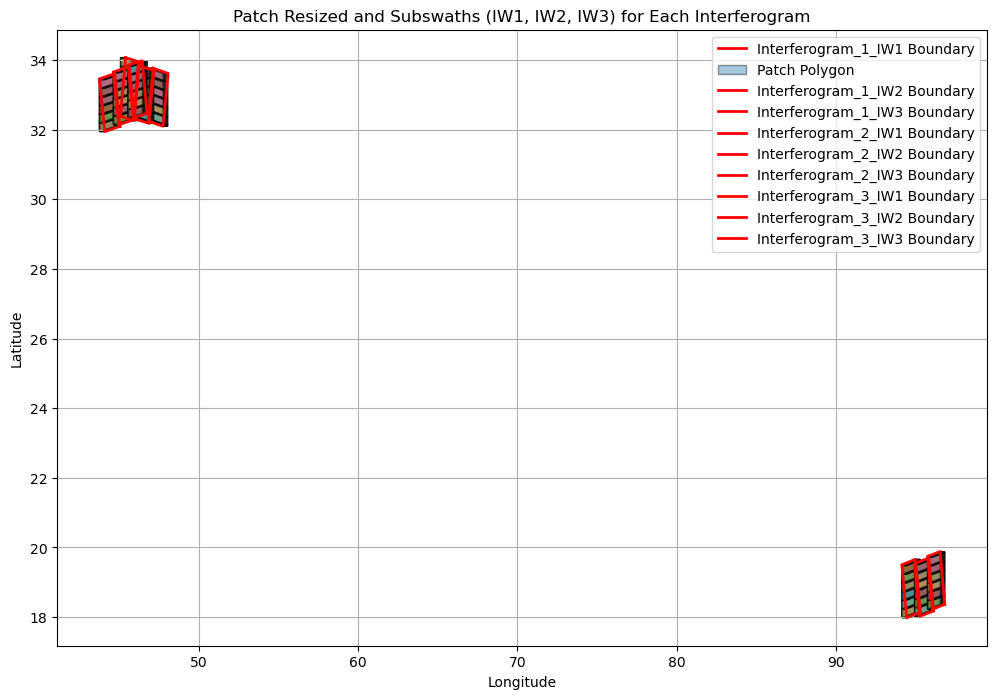

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica i file CSV delle coordinate delle patch ridimensionate e dei metadati
resized_coordinates_df = pd.read_csv('/data3/ebuccoliero/Resized_interferograms/Earthquakes_1_2_3/patch_coordinates.csv')
metadata_df = pd.read_csv('/data3/ebuccoliero/metadata_coordinates_sorted.csv')

# Imposta la figura per il plot
plt.figure(figsize=(12, 8))

# Itera su ciascun interferogramma
for interferogram in resized_coordinates_df['interferogram'].unique():
    # Estrai il subswath dal nome dell'interferogramma
    for subswath in ['IW1', 'IW2', 'IW3']:
        if subswath not in interferogram:
            continue
        
        # Ottieni i metadati corrispondenti
        subs = metadata_df.loc[metadata_df['interferogram'] == interferogram]
        if subs.empty:
            print(f"Nessun metadato trovato per {interferogram}. Saltando...")
            continue

        # Estrai le coordinate del subswath
        subs = subs.iloc[0]
        subswath_coords = [
            (subs['first_far_lat'], subs['first_far_long']),
            (subs['first_near_lat'], subs['first_near_long']),
            (subs['last_near_lat'], subs['last_near_long']),
            (subs['last_far_lat'], subs['last_far_long']),
            (subs['first_far_lat'], subs['first_far_long'])  # Chiudi il loop
        ]

        # Estrai le latitudini e longitudini del subswath
        subswath_lats = [coord[0] for coord in subswath_coords]
        subswath_lons = [coord[1] for coord in subswath_coords]

        # Disegna il contorno dell'area del subswath
        plt.plot(subswath_lons, subswath_lats, 'r-', linewidth=2, label=f'{interferogram} Boundary')

        # Filtra le righe delle patch ridimensionate per l'interferogramma e il subswath correnti
        patches_df = resized_coordinates_df[resized_coordinates_df['interferogram'] == interferogram]

        # Disegna un poligono per ciascuna riga delle patch ridimensionate
        for _, row in patches_df.iterrows():
            lats = [row['lat_top_left'], row['lat_top_right'], row['lat_bottom_right'], row['lat_bottom_left'], row['lat_top_left']]
            lons = [row['lon_top_left'], row['lon_top_right'], row['lon_bottom_right'], row['lon_bottom_left'], row['lon_top_left']]
            plt.fill(lons, lats, alpha=0.4, edgecolor='black', label='Patch Polygon' if _ == 0 else "")

# Configurazione degli assi e del titolo
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Patch Resized and Subswaths (IW1, IW2, IW3) for Each Interferogram')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# do ALL 40 Interferogram

In [23]:
import h5py
import numpy as np
import cv2
import pandas as pd
import os

# Set input and output paths
input_dir = '/data3/ebuccoliero/Images'
output_h5_path = '/data3/ebuccoliero/Resized_interferograms/all_resized_interferograms.h5'
metadata_file_path = '/data3/ebuccoliero/metadata_coordinates_sorted.csv'
output_csv_path = '/data3/ebuccoliero/Resized_interferograms/final_patch_coordinates.csv'

# Load metadata
metadata_df = pd.read_csv(metadata_file_path)

# Define patch size and resize shape
patch_size = 2000
resize_shape = (256, 256)

# List to store patch coordinate information
patch_coordinates = []

# Check if the HDF5 file exists and print its structure
if os.path.exists(output_h5_path):
    print(f"File '{output_h5_path}' exists. Attempting to read structure...")
    with h5py.File(output_h5_path, 'r') as f:
        def print_structure(name, obj):
            print(name)
        f.visititems(print_structure)

# Create or append to the HDF5 file to save patches
with h5py.File(output_h5_path, 'a') as f_out:
    # Iterate over image numbers and subswaths
    for image_index in range(1, 41):
        for subswath in ['IW1', 'IW2', 'IW3']:
            # Input HDF5 path
            input_h5_path = os.path.join(input_dir, f'Image{image_index}/Interferogram_{image_index}_{subswath}.h5')
            
            # Check if input file exists
            if not os.path.exists(input_h5_path):
                print(f"File {input_h5_path} not found. Skipping...")
                continue

            # Get corresponding metadata
            full_name = f'Interferogram_{image_index}_{subswath}'
            subs_metadata = metadata_df.loc[metadata_df['interferogram'] == full_name]
            if subs_metadata.empty:
                print(f"No metadata found for {full_name}. Skipping...")
                continue

            # Extract coordinates from metadata
            subs = subs_metadata.iloc[0]
            first_far = (subs['first_far_lat'], subs['first_far_long'])
            first_near = (subs['first_near_lat'], subs['first_near_long'])
            last_far = (subs['last_far_lat'], subs['last_far_long'])
            last_near = (subs['last_near_lat'], subs['last_near_long'])

            # Read input HDF5 and process bands
            with h5py.File(input_h5_path, 'r') as f_in:
                bands_group = f_in['bands']
                band_names = list(bands_group.keys())

                sample_band = bands_group[band_names[0]][:]
                height, width = sample_band.shape

                for band_name in band_names:
                    band_data = bands_group[band_name][:]

                    for y in range(0, height, patch_size):
                        for x in range(0, width, patch_size):
                            y_end = min(y + patch_size, height)
                            x_end = min(x + patch_size, width)

                            patch = band_data[y:y_end, x:x_end]
                            resized_patch = cv2.resize(patch, resize_shape, interpolation=cv2.INTER_AREA)

                            base_path = f'{full_name}/{band_name}'
                            dataset_name = f'{base_path}/patch_{y}_{x}'
                            f_out.create_dataset(dataset_name, data=resized_patch)

                            lat_top_left = np.interp(y, [0, height], [first_far[0], last_far[0]])
                            lon_top_left = np.interp(x, [0, width], [first_far[1], last_far[1]])
                            lat_top_right = np.interp(y, [0, height], [first_near[0], last_near[0]])
                            lon_top_right = np.interp(x_end, [0, width], [first_near[1], last_near[1]])
                            lat_bottom_left = np.interp(y_end, [0, height], [first_far[0], last_far[0]])
                            lon_bottom_left = np.interp(x, [0, width], [first_far[1], last_far[1]])
                            lat_bottom_right = np.interp(y_end, [0, height], [first_near[0], last_near[0]])
                            lon_bottom_right = np.interp(x_end, [0, width], [first_near[1], last_near[1]])

                            patch_coordinates.append({
                                'interferogram': full_name,
                                'band': band_name,
                                'patch_index': len(patch_coordinates) + 1,
                                'lat_top_left': lat_top_left,
                                'lon_top_left': lon_top_left,
                                'lat_top_right': lat_top_right,
                                'lon_top_right': lon_top_right,
                                'lat_bottom_left': lat_bottom_left,
                                'lon_bottom_left': lon_bottom_left,
                                'lat_bottom_right': lat_bottom_right,
                                'lon_bottom_right': lon_bottom_right
                            })

            print(f"Patches and coordinates for {full_name} have been saved successfully.")

# Save patch coordinates to CSV
patch_coordinates_df = pd.DataFrame(patch_coordinates)
patch_coordinates_df.to_csv(output_csv_path, index=False)

print("All patch coordinates have been successfully saved to CSV.")

Patches and coordinates for Interferogram_1_IW1 have been saved successfully.
Patches and coordinates for Interferogram_1_IW2 have been saved successfully.
Patches and coordinates for Interferogram_1_IW3 have been saved successfully.
Patches and coordinates for Interferogram_2_IW1 have been saved successfully.
Patches and coordinates for Interferogram_2_IW2 have been saved successfully.
Patches and coordinates for Interferogram_2_IW3 have been saved successfully.
Patches and coordinates for Interferogram_3_IW1 have been saved successfully.
Patches and coordinates for Interferogram_3_IW2 have been saved successfully.
Patches and coordinates for Interferogram_3_IW3 have been saved successfully.
Patches and coordinates for Interferogram_4_IW1 have been saved successfully.
Patches and coordinates for Interferogram_4_IW2 have been saved successfully.
Patches and coordinates for Interferogram_4_IW3 have been saved successfully.
Patches and coordinates for Interferogram_5_IW1 have been saved 

In [4]:
import h5py
import os

# Path to the HDF5 file
file_path = '/data3/ebuccoliero/Resized_interferograms/all_resized_interferograms.h5'

# Check if the file exists
if os.path.exists(file_path):
    print(f"File '{file_path}' exists. Attempting to read structure...")

    # Open the file in read mode
    with h5py.File(file_path, 'r') as f:
        # Check if the file has any content
        if len(f.keys()) == 0:
            print("The file is empty or does not contain any groups or datasets.")
        else:
            # Define a function to recursively print the file structure
            def print_structure(name, obj):
                # Print the name of each object in the file (group or dataset)
                print(name)

            # Print the entire structure
            print("File structure:")
            f.visititems(print_structure)

else:
    print(f"File '{file_path}' does not exist. Please check the file path.")

File '/data3/ebuccoliero/Resized_interferograms/all_resized_interferograms.h5' exists. Attempting to read structure...
File structure:
Interferogram_10_IW1
Interferogram_10_IW1/coh_IW1_VV_03Feb2018_15Feb2018
Interferogram_10_IW1/coh_IW1_VV_03Feb2018_15Feb2018/patch_0_0
Interferogram_10_IW1/coh_IW1_VV_03Feb2018_15Feb2018/patch_0_10000
Interferogram_10_IW1/coh_IW1_VV_03Feb2018_15Feb2018/patch_0_12000
Interferogram_10_IW1/coh_IW1_VV_03Feb2018_15Feb2018/patch_0_14000
Interferogram_10_IW1/coh_IW1_VV_03Feb2018_15Feb2018/patch_0_16000
Interferogram_10_IW1/coh_IW1_VV_03Feb2018_15Feb2018/patch_0_18000
Interferogram_10_IW1/coh_IW1_VV_03Feb2018_15Feb2018/patch_0_2000
Interferogram_10_IW1/coh_IW1_VV_03Feb2018_15Feb2018/patch_0_20000
Interferogram_10_IW1/coh_IW1_VV_03Feb2018_15Feb2018/patch_0_4000
Interferogram_10_IW1/coh_IW1_VV_03Feb2018_15Feb2018/patch_0_6000
Interferogram_10_IW1/coh_IW1_VV_03Feb2018_15Feb2018/patch_0_8000
Interferogram_10_IW1/coh_IW1_VV_03Feb2018_15Feb2018/patch_10000_0
Interfer

In [8]:
import pandas as pd

# Load the CSV files
file1 = '/data3/ebuccoliero/Merged_Bands_and_Data_Type.csv'
file2 = '/data3/ebuccoliero/patch_coordinates_with_distance.csv'

# Read the CSV files into DataFrames
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Perform the join operation to keep all columns based on 'interferogram' and 'band'
combined_df = pd.merge(df2, df1, on=['interferogram', 'band'], how='left')


# Remove the columns 'key' and 'Unnamed', if they exist
df = combined_df.drop(columns=['Key', 'Unnamed:0'], errors='ignore')

# Save the modified DataFrame to a new CSV file
output_file_path = 'combined_interferogram_analysis.csv'
df.to_csv(output_file_path, index=False)


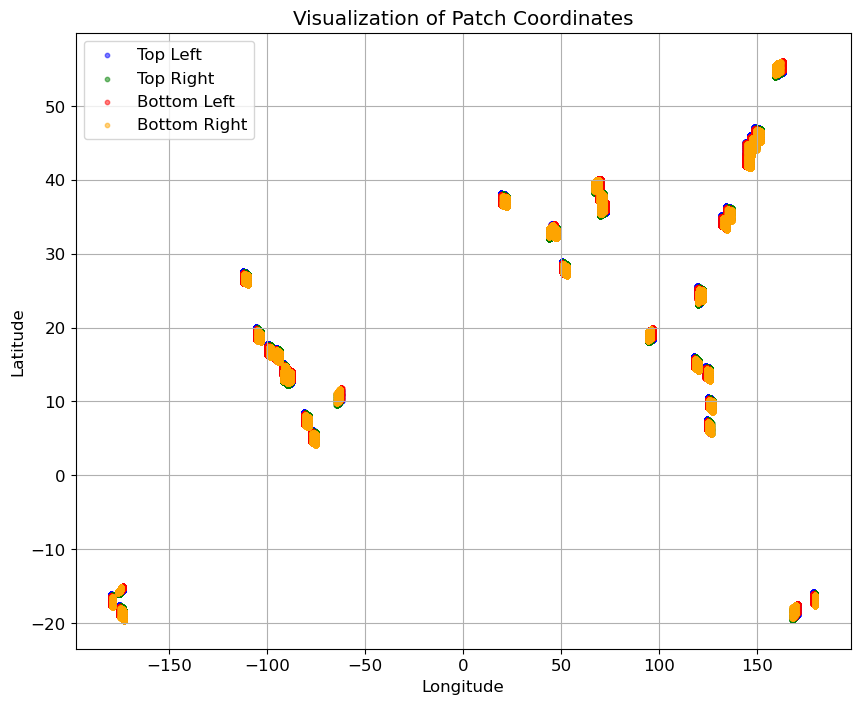

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il file CSV
file_path = '/data3/ebuccoliero/Resized_interferograms/final_patch_coordinates.csv'  # Sostituisci con il percorso del tuo file
df = pd.read_csv(file_path)

# Creare il grafico
plt.figure(figsize=(10, 8))
plt.scatter(df['lon_top_left'], df['lat_top_left'], color='blue', label='Top Left', alpha=0.5, s=10)
plt.scatter(df['lon_top_right'], df['lat_top_right'], color='green', label='Top Right', alpha=0.5, s=10)
plt.scatter(df['lon_bottom_left'], df['lat_bottom_left'], color='red', label='Bottom Left', alpha=0.5, s=10)
plt.scatter(df['lon_bottom_right'], df['lat_bottom_right'], color='orange', label='Bottom Right', alpha=0.5, s=10)

# Aggiungi etichette e titolo
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Visualization of Patch Coordinates')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
#for eaxample

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.img_tiles import OSM

# Load the CSV file
file_path = '/data3/ebuccoliero/Resized_interferograms/final_patch_coordinates.csv'  # Update with your file path
df = pd.read_csv(file_path)

# Filter the DataFrame to include only rows for "Interferogram_1"
filtered_df_interferogram_1 = df[df['interferogram'].str.contains("Interferogram_1_")]

# Create polygons for each patch
polygons = []
for _, row in filtered_df_interferogram_1.iterrows():
    corners = [
        (row['lon_top_left'], row['lat_top_left']),
        (row['lon_top_right'], row['lat_top_right']),
        (row['lon_bottom_right'], row['lat_bottom_right']),
        (row['lon_bottom_left'], row['lat_bottom_left']),
        (row['lon_top_left'], row['lat_top_left'])  # Closing the polygon
    ]
    polygons.append(Polygon(corners))

# Create a GeoDataFrame for all patches
patches_gdf = gpd.GeoDataFrame(geometry=polygons, crs="EPSG:4326")

# Plotting the patches on a map with Cartopy
fig, ax = plt.subplots(figsize=(15, 11), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

# Determine the extent to zoom into the area of interest
min_lon, min_lat, max_lon, max_lat = patches_gdf.total_bounds
margin = 0.2  # Add a small margin for better visualization
ax.set_extent([min_lon - margin, max_lon + margin, min_lat - margin, max_lat + margin])

# Add OSM background map
tile = OSM()
ax.add_image(tile, 8)  # Adjust the zoom level as needed

# Plot each patch
patches_gdf.plot(ax=ax, edgecolor='red', alpha=0.4, facecolor='blue', transform=ccrs.PlateCarree())

# Configure the plot
plt.title('Visualization of All Patches for Interferogram 1 on a Map')
plt.show()

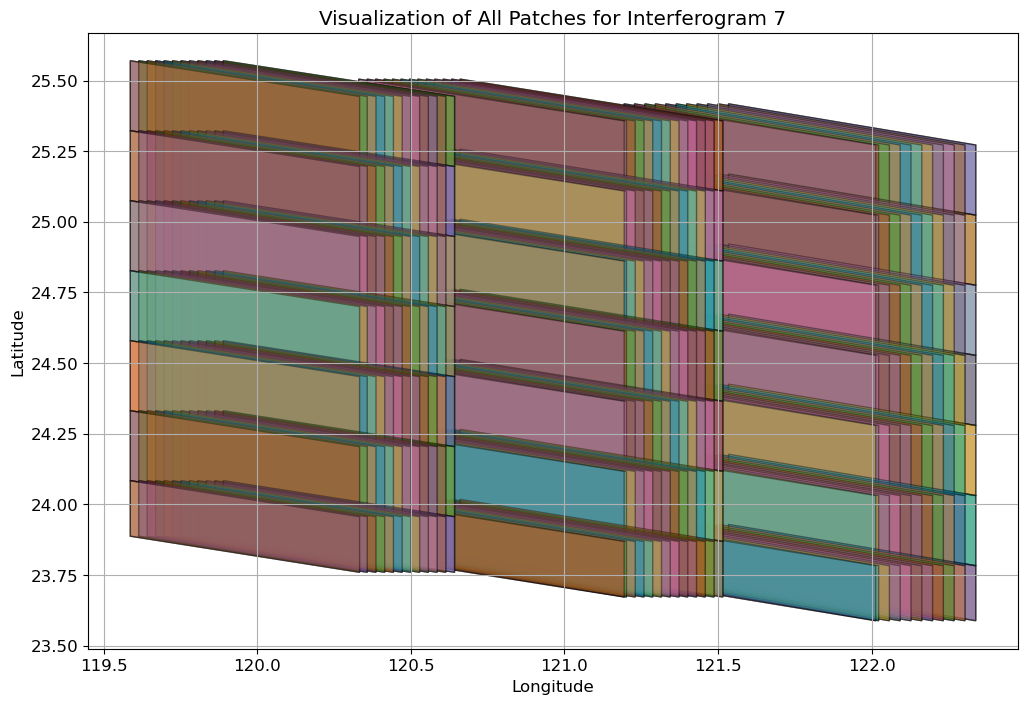

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica il file CSV
file_path = '/data3/ebuccoliero/Resized_interferograms/final_patch_coordinates.csv'   # Sostituisci con il percorso del tuo file
df = pd.read_csv(file_path)

# Filtra il dataframe per includere solo le righe di "Interferogram 7"
filtered_df_interferogram_7 = df[df['interferogram'].str.contains("Interferogram_7_")]

# Imposta la figura per il plot
plt.figure(figsize=(12, 8))
for _, row in filtered_df_interferogram_7.iterrows():
    lats = [row['lat_top_left'], row['lat_top_right'], row['lat_bottom_right'], row['lat_bottom_left'], row['lat_top_left']]
    lons = [row['lon_top_left'], row['lon_top_right'], row['lon_bottom_right'], row['lon_bottom_left'], row['lon_top_left']]
    plt.fill(lons, lats, alpha=0.4, edgecolor='black')

# Configurazione degli assi e del titolo
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Visualization of All Patches for Interferogram 7')
plt.grid(True)
plt.show()

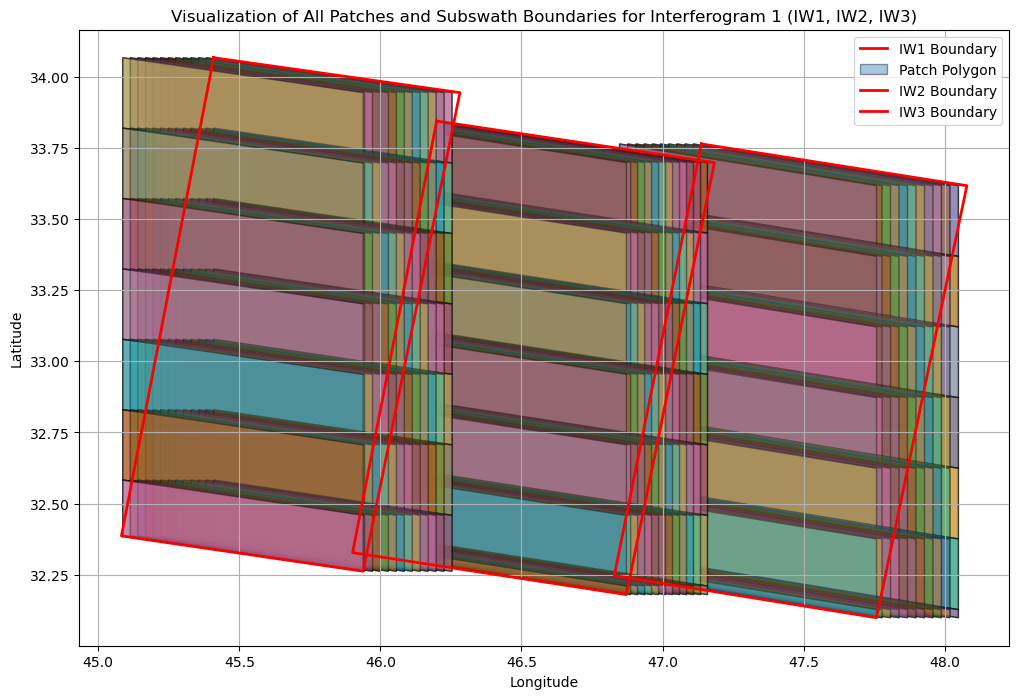

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica i file CSV
file_path = '/data3/ebuccoliero/Resized_interferograms/final_patch_coordinates.csv'  # Sostituisci con il percorso del file dei patch
metadata_file_path = '/data3/ebuccoliero/metadata_coordinates_sorted.csv'  # Sostituisci con il percorso del file dei metadati
df = pd.read_csv(file_path)
metadata_df = pd.read_csv(metadata_file_path)

# Filtra il dataframe per includere solo le righe di "Interferogram 7"
filtered_df_interferogram_7 = df[df['interferogram'].str.contains("Interferogram_1_")]

# Definisci i subswath
subswaths = ['IW1', 'IW2', 'IW3']
plt.figure(figsize=(12, 8))

# Itera su ciascun subswath e crea il grafico
for subswath in subswaths:
    # Filtra i metadati per il subswath corrente
    metadata_subswath = metadata_df[metadata_df['interferogram'].str.contains(f"Interferogram_1_{subswath}")]
    
    if not metadata_subswath.empty:
        # Estrai la prima riga di coordinate
        metadata_row = metadata_subswath.iloc[0]
        subswath_coords = [
            (metadata_row['first_far_lat'], metadata_row['first_far_long']),
            (metadata_row['first_near_lat'], metadata_row['first_near_long']),
            (metadata_row['last_near_lat'], metadata_row['last_near_long']),
            (metadata_row['last_far_lat'], metadata_row['last_far_long']),
            (metadata_row['first_far_lat'], metadata_row['first_far_long'])  # Chiudi il loop
        ]

        # Estrai le latitudini e longitudini per il contorno del poligono
        subswath_lats = [coord[0] for coord in subswath_coords]
        subswath_lons = [coord[1] for coord in subswath_coords]

        # Disegna il contorno del subswath
        plt.plot(subswath_lons, subswath_lats, 'r-', linewidth=2, label=f'{subswath} Boundary')

    # Filtra i patch per il subswath corrente
    patches_df = filtered_df_interferogram_7[filtered_df_interferogram_7['interferogram'].str.contains(subswath)]
    
    # Disegna tutti i patch per il subswath corrente
    for _, row in patches_df.iterrows():
        lats = [row['lat_top_left'], row['lat_top_right'], row['lat_bottom_right'], row['lat_bottom_left'], row['lat_top_left']]
        lons = [row['lon_top_left'], row['lon_top_right'], row['lon_bottom_right'], row['lon_bottom_left'], row['lon_top_left']]
        plt.fill(lons, lats, alpha=0.4, edgecolor='black', label='Patch Polygon' if _ == 0 else "")

# Configurazione degli assi e del titolo
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Visualization of All Patches and Subswath Boundaries for Interferogram 1 (IW1, IW2, IW3)')
plt.legend()
plt.grid(True)
plt.show()

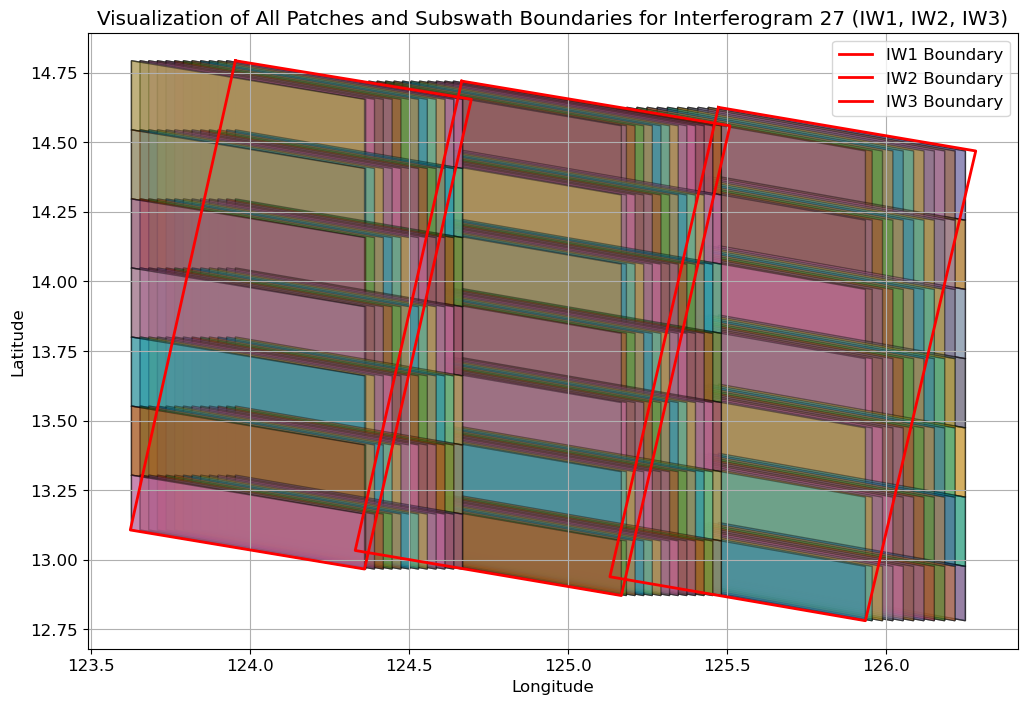

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica i file CSV
file_path = '/data3/ebuccoliero/Resized_interferograms/final_patch_coordinates.csv'  # Sostituisci con il percorso del file dei patch
metadata_file_path = '/data3/ebuccoliero/metadata_coordinates_sorted.csv'  # Sostituisci con il percorso del file dei metadati
df = pd.read_csv(file_path)
metadata_df = pd.read_csv(metadata_file_path)

# Filtra il dataframe per includere solo le righe di "Interferogram 7"
filtered_df_interferogram_7 = df[df['interferogram'].str.contains("Interferogram_27_")]

# Definisci i subswath
subswaths = ['IW1', 'IW2', 'IW3']
plt.figure(figsize=(12, 8))

# Itera su ciascun subswath e crea il grafico
for subswath in subswaths:
    # Filtra i metadati per il subswath corrente
    metadata_subswath = metadata_df[metadata_df['interferogram'].str.contains(f"Interferogram_27_{subswath}")]
    
    if not metadata_subswath.empty:
        # Estrai la prima riga di coordinate
        metadata_row = metadata_subswath.iloc[0]
        subswath_coords = [
            (metadata_row['first_far_lat'], metadata_row['first_far_long']),
            (metadata_row['first_near_lat'], metadata_row['first_near_long']),
            (metadata_row['last_near_lat'], metadata_row['last_near_long']),
            (metadata_row['last_far_lat'], metadata_row['last_far_long']),
            (metadata_row['first_far_lat'], metadata_row['first_far_long'])  # Chiudi il loop
        ]

        # Estrai le latitudini e longitudini per il contorno del poligono
        subswath_lats = [coord[0] for coord in subswath_coords]
        subswath_lons = [coord[1] for coord in subswath_coords]

        # Disegna il contorno del subswath
        plt.plot(subswath_lons, subswath_lats, 'r-', linewidth=2, label=f'{subswath} Boundary')

    # Filtra i patch per il subswath corrente
    patches_df = filtered_df_interferogram_7[filtered_df_interferogram_7['interferogram'].str.contains(subswath)]
    
    # Disegna tutti i patch per il subswath corrente
    for _, row in patches_df.iterrows():
        lats = [row['lat_top_left'], row['lat_top_right'], row['lat_bottom_right'], row['lat_bottom_left'], row['lat_top_left']]
        lons = [row['lon_top_left'], row['lon_top_right'], row['lon_bottom_right'], row['lon_bottom_left'], row['lon_top_left']]
        plt.fill(lons, lats, alpha=0.4, edgecolor='black', label='Patch Polygon' if _ == 0 else "")

# Configurazione degli assi e del titolo
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Visualization of All Patches and Subswath Boundaries for Interferogram 27 (IW1, IW2, IW3)')
plt.legend()
plt.grid(True)
plt.show()

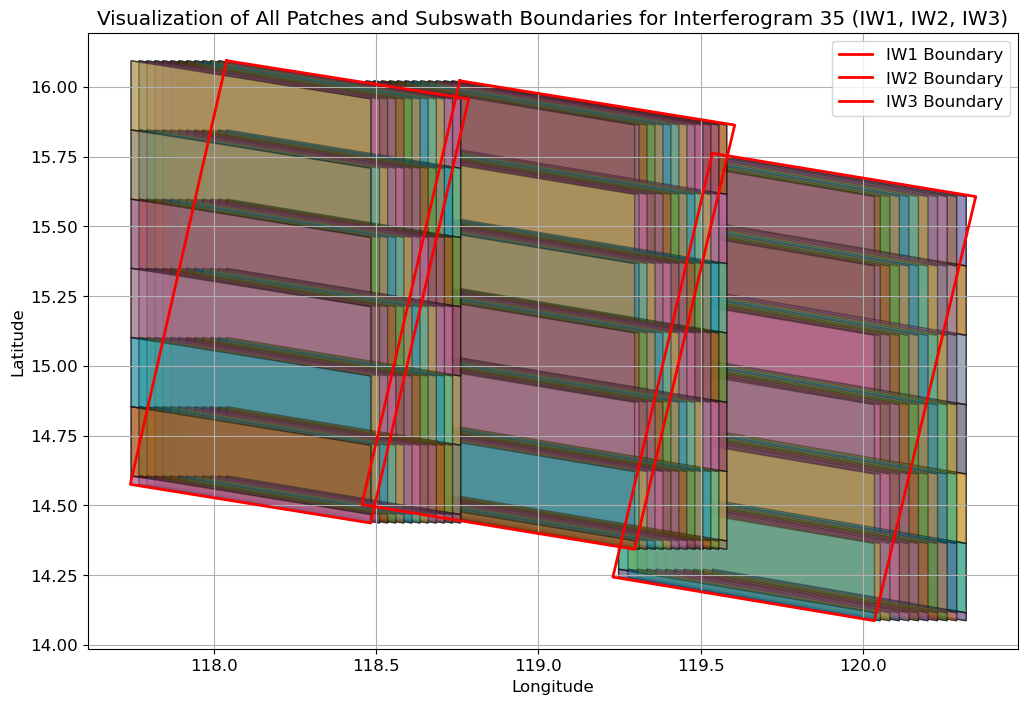

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica i file CSV
file_path = '/data3/ebuccoliero/Resized_interferograms/final_patch_coordinates.csv'  # Sostituisci con il percorso del file dei patch
metadata_file_path = '/data3/ebuccoliero/metadata_coordinates_sorted.csv'  # Sostituisci con il percorso del file dei metadati
df = pd.read_csv(file_path)
metadata_df = pd.read_csv(metadata_file_path)

# Filtra il dataframe per includere solo le righe di "Interferogram 7"
filtered_df_interferogram_7 = df[df['interferogram'].str.contains("Interferogram_35_")]

# Definisci i subswath
subswaths = ['IW1', 'IW2', 'IW3']
plt.figure(figsize=(12, 8))

# Itera su ciascun subswath e crea il grafico
for subswath in subswaths:
    # Filtra i metadati per il subswath corrente
    metadata_subswath = metadata_df[metadata_df['interferogram'].str.contains(f"Interferogram_35_{subswath}")]
    
    if not metadata_subswath.empty:
        # Estrai la prima riga di coordinate
        metadata_row = metadata_subswath.iloc[0]
        subswath_coords = [
            (metadata_row['first_far_lat'], metadata_row['first_far_long']),
            (metadata_row['first_near_lat'], metadata_row['first_near_long']),
            (metadata_row['last_near_lat'], metadata_row['last_near_long']),
            (metadata_row['last_far_lat'], metadata_row['last_far_long']),
            (metadata_row['first_far_lat'], metadata_row['first_far_long'])  # Chiudi il loop
        ]

        # Estrai le latitudini e longitudini per il contorno del poligono
        subswath_lats = [coord[0] for coord in subswath_coords]
        subswath_lons = [coord[1] for coord in subswath_coords]

        # Disegna il contorno del subswath
        plt.plot(subswath_lons, subswath_lats, 'r-', linewidth=2, label=f'{subswath} Boundary')

    # Filtra i patch per il subswath corrente
    patches_df = filtered_df_interferogram_7[filtered_df_interferogram_7['interferogram'].str.contains(subswath)]
    
    # Disegna tutti i patch per il subswath corrente
    for _, row in patches_df.iterrows():
        lats = [row['lat_top_left'], row['lat_top_right'], row['lat_bottom_right'], row['lat_bottom_left'], row['lat_top_left']]
        lons = [row['lon_top_left'], row['lon_top_right'], row['lon_bottom_right'], row['lon_bottom_left'], row['lon_top_left']]
        plt.fill(lons, lats, alpha=0.4, edgecolor='black', label='Patch Polygon' if _ == 0 else "")

# Configurazione degli assi e del titolo
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Visualization of All Patches and Subswath Boundaries for Interferogram 35 (IW1, IW2, IW3)')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
#with the EPICENTER

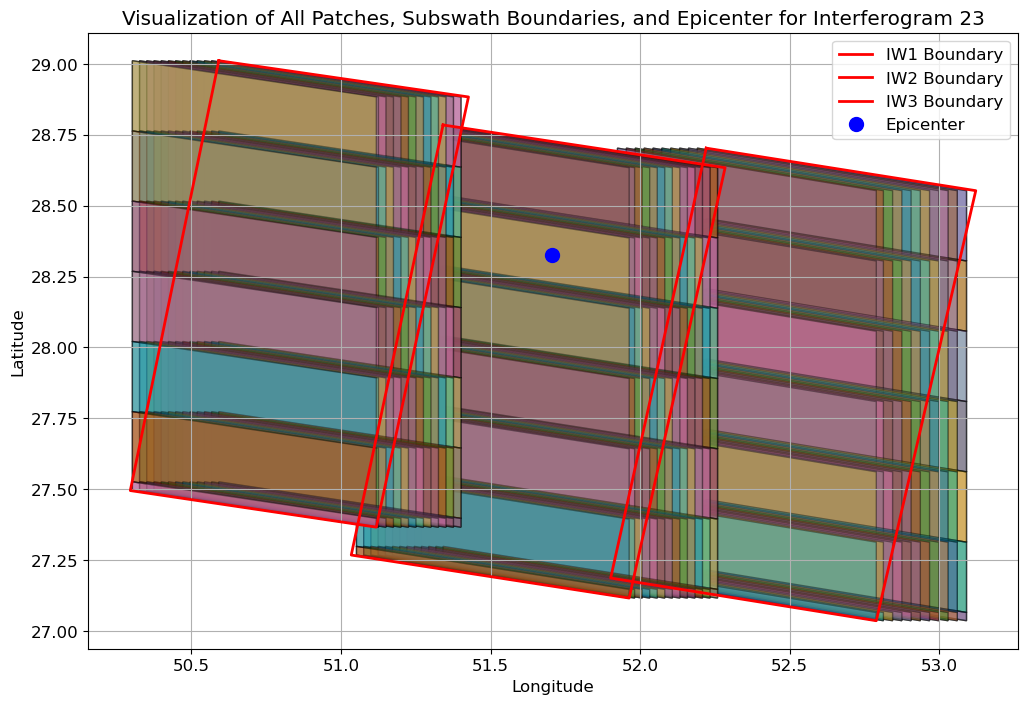

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica i file CSV
file_path = '/data3/ebuccoliero/Resized_interferograms/final_patch_coordinates.csv'
metadata_file_path = '/data3/ebuccoliero/metadata_coordinates_sorted.csv'
earthquake_file_path = 'filtered_earthquake_data.csv'

df = pd.read_csv(file_path)
metadata_df = pd.read_csv(metadata_file_path)
earthquake_data = pd.read_csv(earthquake_file_path)

# Filtra i dati del terremoto per selezionare l'epicentro corrispondente a "Interferogram 35"
epicenter_info = earthquake_data[earthquake_data['index'] == 23]
epicenter_lat = epicenter_info['latitude'].values[0]
epicenter_lon = epicenter_info['longitude'].values[0]

# Definisci i subswath
subswaths = ['IW1', 'IW2', 'IW3']

# Crea il grafico
plt.figure(figsize=(12, 8))

# Filtra il dataframe per "Interferogram 35"
filtered_df_interferogram_35 = df[df['interferogram'].str.contains("Interferogram_23_")]

# Itera su ciascun subswath e disegna i contorni
for subswath in subswaths:
    metadata_subswath = metadata_df[metadata_df['interferogram'].str.contains(f"Interferogram_23_{subswath}")]
    
    if not metadata_subswath.empty:
        metadata_row = metadata_subswath.iloc[0]
        subswath_coords = [
            (metadata_row['first_far_lat'], metadata_row['first_far_long']),
            (metadata_row['first_near_lat'], metadata_row['first_near_long']),
            (metadata_row['last_near_lat'], metadata_row['last_near_long']),
            (metadata_row['last_far_lat'], metadata_row['last_far_long']),
            (metadata_row['first_far_lat'], metadata_row['first_far_long'])  # Chiudi il loop
        ]

        subswath_lats = [coord[0] for coord in subswath_coords]
        subswath_lons = [coord[1] for coord in subswath_coords]

        plt.plot(subswath_lons, subswath_lats, 'r-', linewidth=2, label=f'{subswath} Boundary')

# Disegna tutti i patch per "Interferogram 35"
for _, row in filtered_df_interferogram_35.iterrows():
    lats = [row['lat_top_left'], row['lat_top_right'], row['lat_bottom_right'], row['lat_bottom_left'], row['lat_top_left']]
    lons = [row['lon_top_left'], row['lon_top_right'], row['lon_bottom_right'], row['lon_bottom_left'], row['lon_top_left']]
    plt.fill(lons, lats, alpha=0.4, edgecolor='black', label='Patch Polygon' if _ == 0 else "")

# Disegna l'epicentro
plt.plot(epicenter_lon, epicenter_lat, 'bo', markersize=10, label='Epicenter')

# Configura gli assi e il titolo
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Visualization of All Patches, Subswath Boundaries, and Epicenter for Interferogram 23')
plt.legend()
plt.grid(True)
plt.show()


/home/ebuccoliero/miniforge3/envs/snappp/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


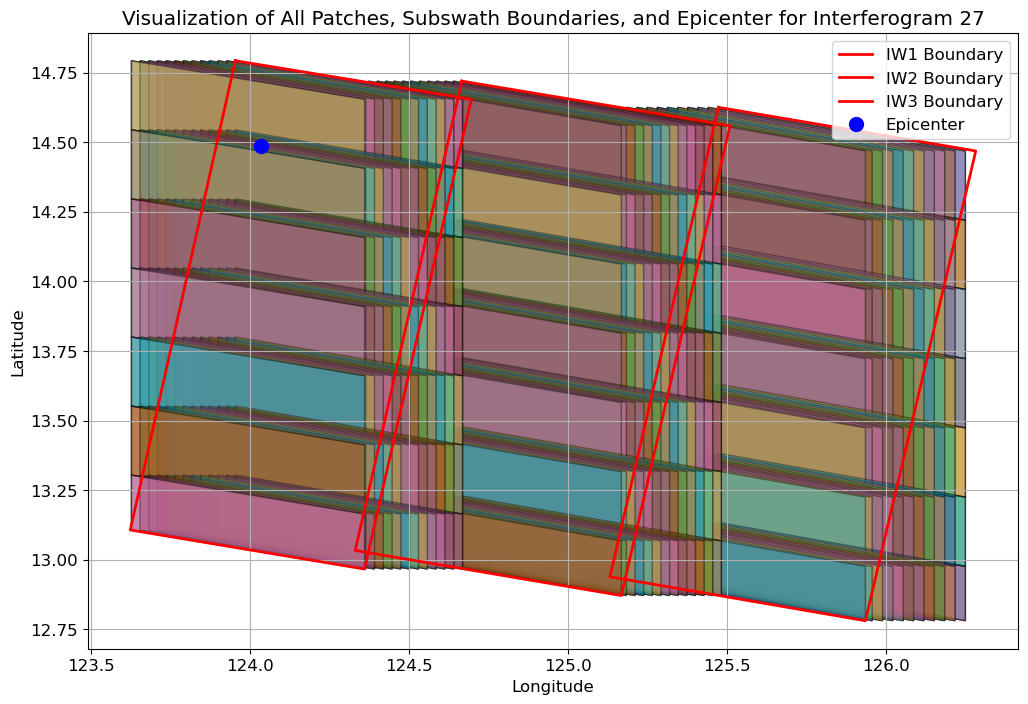

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica i file CSV
file_path = '/data3/ebuccoliero/Resized_interferograms/final_patch_coordinates.csv'
metadata_file_path = '/data3/ebuccoliero/metadata_coordinates_sorted.csv'
earthquake_file_path = 'filtered_earthquake_data.csv'

df = pd.read_csv(file_path)
metadata_df = pd.read_csv(metadata_file_path)
earthquake_data = pd.read_csv(earthquake_file_path)

# Filtra i dati del terremoto per selezionare l'epicentro corrispondente a "Interferogram 35"
epicenter_info = earthquake_data[earthquake_data['index'] == 27]
epicenter_lat = epicenter_info['latitude'].values[0]
epicenter_lon = epicenter_info['longitude'].values[0]

# Definisci i subswath
subswaths = ['IW1', 'IW2', 'IW3']

# Crea il grafico
plt.figure(figsize=(12, 8))

# Filtra il dataframe per "Interferogram 35"
filtered_df_interferogram_35 = df[df['interferogram'].str.contains("Interferogram_27_")]

# Itera su ciascun subswath e disegna i contorni
for subswath in subswaths:
    metadata_subswath = metadata_df[metadata_df['interferogram'].str.contains(f"Interferogram_27_{subswath}")]
    
    if not metadata_subswath.empty:
        metadata_row = metadata_subswath.iloc[0]
        subswath_coords = [
            (metadata_row['first_far_lat'], metadata_row['first_far_long']),
            (metadata_row['first_near_lat'], metadata_row['first_near_long']),
            (metadata_row['last_near_lat'], metadata_row['last_near_long']),
            (metadata_row['last_far_lat'], metadata_row['last_far_long']),
            (metadata_row['first_far_lat'], metadata_row['first_far_long'])  # Chiudi il loop
        ]

        subswath_lats = [coord[0] for coord in subswath_coords]
        subswath_lons = [coord[1] for coord in subswath_coords]

        plt.plot(subswath_lons, subswath_lats, 'r-', linewidth=2, label=f'{subswath} Boundary')

# Disegna tutti i patch per "Interferogram 35"
for _, row in filtered_df_interferogram_35.iterrows():
    lats = [row['lat_top_left'], row['lat_top_right'], row['lat_bottom_right'], row['lat_bottom_left'], row['lat_top_left']]
    lons = [row['lon_top_left'], row['lon_top_right'], row['lon_bottom_right'], row['lon_bottom_left'], row['lon_top_left']]
    plt.fill(lons, lats, alpha=0.4, edgecolor='black', label='Patch Polygon' if _ == 0 else "")

# Disegna l'epicentro
plt.plot(epicenter_lon, epicenter_lat, 'bo', markersize=10, label='Epicenter')

# Configura gli assi e il titolo
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Visualization of All Patches, Subswath Boundaries, and Epicenter for Interferogram 27')
plt.legend()
plt.grid(True)
plt.show()

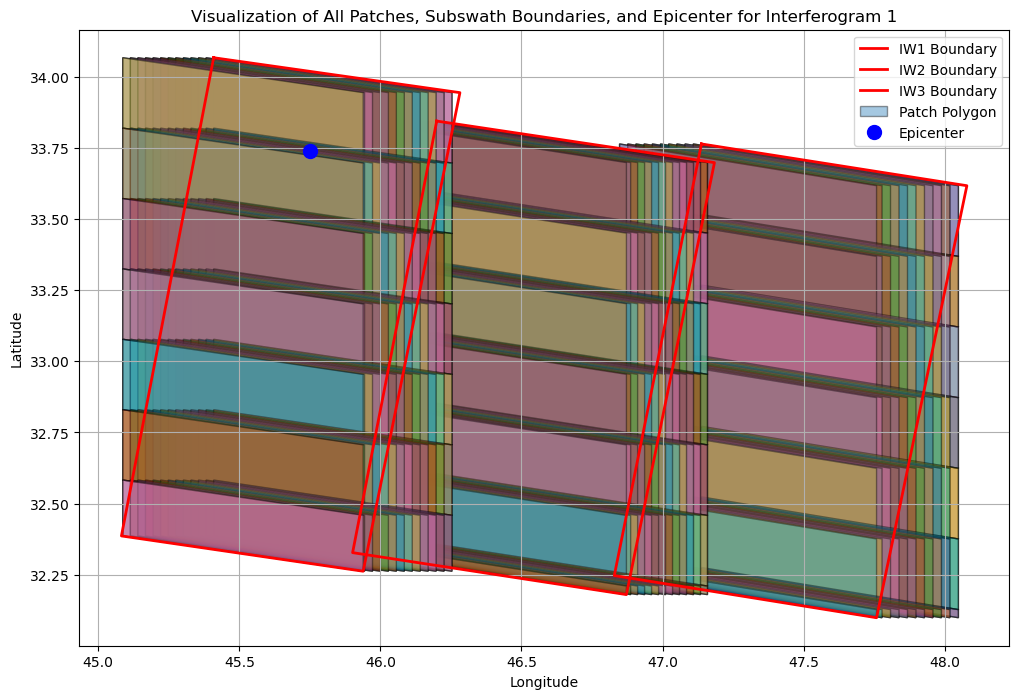

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica i file CSV
file_path = '/data3/ebuccoliero/Resized_interferograms/final_patch_coordinates.csv'
metadata_file_path = '/data3/ebuccoliero/metadata_coordinates_sorted.csv'
earthquake_file_path = 'filtered_earthquake_data.csv'

df = pd.read_csv(file_path)
metadata_df = pd.read_csv(metadata_file_path)
earthquake_data = pd.read_csv(earthquake_file_path)

# Filtra i dati del terremoto per selezionare l'epicentro corrispondente a "Interferogram 35"
epicenter_info = earthquake_data[earthquake_data['index'] == 1]
epicenter_lat = epicenter_info['latitude'].values[0]
epicenter_lon = epicenter_info['longitude'].values[0]

# Definisci i subswath
subswaths = ['IW1', 'IW2', 'IW3']

# Crea il grafico
plt.figure(figsize=(12, 8))

# Filtra il dataframe per "Interferogram 35"
filtered_df_interferogram_35 = df[df['interferogram'].str.contains("Interferogram_1_")]

# Itera su ciascun subswath e disegna i contorni
for subswath in subswaths:
    metadata_subswath = metadata_df[metadata_df['interferogram'].str.contains(f"Interferogram_1_{subswath}")]
    
    if not metadata_subswath.empty:
        metadata_row = metadata_subswath.iloc[0]
        subswath_coords = [
            (metadata_row['first_far_lat'], metadata_row['first_far_long']),
            (metadata_row['first_near_lat'], metadata_row['first_near_long']),
            (metadata_row['last_near_lat'], metadata_row['last_near_long']),
            (metadata_row['last_far_lat'], metadata_row['last_far_long']),
            (metadata_row['first_far_lat'], metadata_row['first_far_long'])  # Chiudi il loop
        ]

        subswath_lats = [coord[0] for coord in subswath_coords]
        subswath_lons = [coord[1] for coord in subswath_coords]

        plt.plot(subswath_lons, subswath_lats, 'r-', linewidth=2, label=f'{subswath} Boundary')

# Disegna tutti i patch per "Interferogram 35"
for _, row in filtered_df_interferogram_35.iterrows():
    lats = [row['lat_top_left'], row['lat_top_right'], row['lat_bottom_right'], row['lat_bottom_left'], row['lat_top_left']]
    lons = [row['lon_top_left'], row['lon_top_right'], row['lon_bottom_right'], row['lon_bottom_left'], row['lon_top_left']]
    plt.fill(lons, lats, alpha=0.4, edgecolor='black', label='Patch Polygon' if _ == 0 else "")

# Disegna l'epicentro
plt.plot(epicenter_lon, epicenter_lat, 'bo', markersize=10, label='Epicenter')

# Configura gli assi e il titolo
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Visualization of All Patches, Subswath Boundaries, and Epicenter for Interferogram 1')
plt.legend()
plt.grid(True)
plt.show()

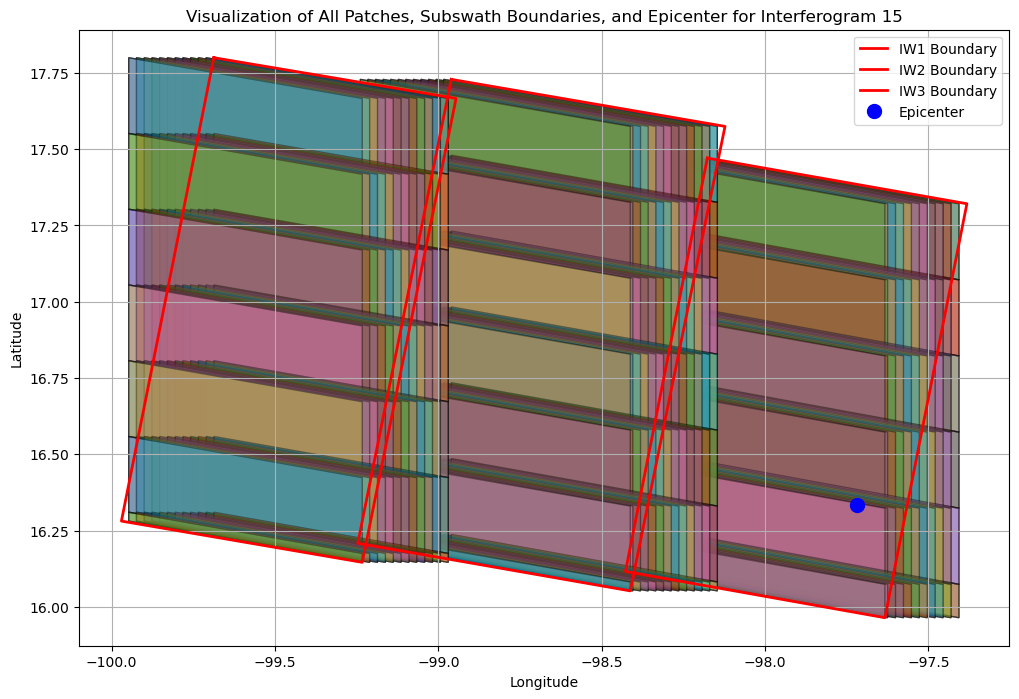

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Carica i file CSV
file_path = '/data3/ebuccoliero/reordered_patch_coordinates_with_distance_rounded.csv'
metadata = '/data3/ebuccoliero/metadata_coordinates_sorted.csv'

df = pd.read_csv(file_path)
metadata_df= pd.read_csv(metadata)

# Filtra i dati del terremoto per selezionare l'epicentro corrispondente a "Interferogram 35"
epicenter_info = df[df['index'] == 15]
epicenter_lat = epicenter_info['epicenter_lat'].values[0]
epicenter_lon = epicenter_info['epicenter_lon'].values[0]

# Definisci i subswath
subswaths = ['IW1', 'IW2', 'IW3']

# Crea il grafico
plt.figure(figsize=(12, 8))

# Filtra il dataframe per "Interferogram 35"
filtered_df_interferogram_1 = df[df['interferogram'].str.contains("Interferogram_15_")]

# Itera su ciascun subswath e disegna i contorni
for subswath in subswaths:
    metadata_subswath = metadata_df[metadata_df['interferogram'].str.contains(f"Interferogram_15_{subswath}")]
    
    if not metadata_subswath.empty:
        metadata_row = metadata_subswath.iloc[0]
        subswath_coords = [
            (metadata_row['first_far_lat'], metadata_row['first_far_long']),
            (metadata_row['first_near_lat'], metadata_row['first_near_long']),
            (metadata_row['last_near_lat'], metadata_row['last_near_long']),
            (metadata_row['last_far_lat'], metadata_row['last_far_long']),
            (metadata_row['first_far_lat'], metadata_row['first_far_long'])  # Chiudi il loop
        ]

        subswath_lats = [coord[0] for coord in subswath_coords]
        subswath_lons = [coord[1] for coord in subswath_coords]

        plt.plot(subswath_lons, subswath_lats, 'r-', linewidth=2, label=f'{subswath} Boundary')

# Disegna tutti i patch per "Interferogram 35"
for _, row in filtered_df_interferogram_1.iterrows():
    lats = [row['lat_top_left'], row['lat_top_right'], row['lat_bottom_right'], row['lat_bottom_left'], row['lat_top_left']]
    lons = [row['lon_top_left'], row['lon_top_right'], row['lon_bottom_right'], row['lon_bottom_left'], row['lon_top_left']]
    plt.fill(lons, lats, alpha=0.4, edgecolor='black', label='Patch Polygon' if _ == 0 else "")

# Disegna l'epicentro
plt.plot(epicenter_lon, epicenter_lat, 'bo', markersize=10, label='Epicenter')

# Configura gli assi e il titolo
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Visualization of All Patches, Subswath Boundaries, and Epicenter for Interferogram 15')
plt.legend()
plt.grid(True)
plt.show()